# NLP_State Gov Complaint / Question Classification Project

### Проект группы развития медиааналитики в г. Москва

## Задача

Необходимо обучить модель, которая будет присваивать сообщениям пользователей класс - *жалоба / вопрос.*

## Методология проекта

1. Сделать первичную обработку данных.
2. Обучить модели классификации, начиная с baselines.
3. Оценить качество классификации разных моделей по метрикам качества выбрать лучшую.
4. Сделать выводы.

## Данные

В качестве данных предложен файл, содержащий в себе вопросы в адрес государственных и муниципальных органов, которые пользователи оставили в социальных сетях. Файл с данными находиться [здесь](https://docs.google.com/spreadsheets/d/1VoONQ5Li6hYFv1SGmUKEWdnm7wYDmWYi/edit?usp=sharing&ouid=117398067332429699807&rtpof=true&sd=true).


In [1]:
import nltk
import pandas as pd

from functools import lru_cache

import fasttext.util
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from gensim.models import word2vec
from pymorphy2 import MorphAnalyzer

# загрузка модели Word2Vec для английского языка
nltk.download('stopwords')
import warnings

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer # TfidfVectorizer преобразует тексты в числовые векторы, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.model_selection import GridSearchCV # модуль поиска по сетке параметров

from sklearn.pipeline import Pipeline

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

from tqdm import tqdm
# pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import warnings

import matplotlib.pyplot as plt
import numpy as np
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from functools import lru_cache

from catboost import CatBoostClassifier
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs
from pymystem3 import Mystem
from multiprocessing import Pool
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('snowball_data')
nltk.download('perluniprops')
nltk.download('universal_tagset')
nltk.download('nonbreaking_prefixes')
nltk.download('wordnet')

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package snowball_data to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading pa

In [2]:
# в nltk много токенизаторов
from nltk import tokenize
dir(tokenize)[:16]

['BlanklineTokenizer',
 'LegalitySyllableTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'NLTKWordTokenizer',
 'PunktSentenceTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'SyllableTokenizer',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer',
 'TreebankWordDetokenizer']

In [3]:
from nltk.corpus import stopwords

# смотрим, какие языки есть
stopwords.fileids()

['arabic',
 'azerbaijani',
 'basque',
 'bengali',
 'catalan',
 'chinese',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hebrew',
 'hinglish',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

In [4]:
# выведем все стоп-слова русского языка
sw = stopwords.words('russian')
print(sw)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

## Загрузка и изучение данных

In [5]:
df = pd.read_excel("C:\\Users\\HOME\\PycharmProjects\\Data_scientist_NLP_данные.xlsx")
df.head(20)

,Дата,Категория,Тема,Муниципалитет,Текст
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ..."
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года..."
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что..."


In [6]:
df.columns

Index(['Дата', 'Категория', 'Тема', 'Муниципалитет', 'Текст'], dtype='object')

In [7]:
# rename the columns
d = df.rename(columns={'Категория': 'category',
                        'Тема': 'topic',
                        'Муниципалитет': 'municipality',
                        'Текст': 'text',
                       'Дата': 'date'})

# print the DataFrame to verify the column names
print(d.columns)
d

Index(['date', 'category', 'topic', 'municipality', 'text'], dtype='object')


,date,category,topic,municipality,text
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ..."
...,...,...,...,...,...
29544,2022-04-11 08:42:35.514,Вопрос,Общественный транспорт,Октябрьский г,'Добрый день.Почему подорожала плата за проезд...
29545,2022-05-04 07:38:28.007,Вопрос,"МФЦ ""Мои документы""",Миасс г,'Миасс. Девочки подскажите номер телефона пф о...
29546,2022-04-15 19:15:52.086,Вопрос,Социальное обслуживание и защита,Уфа г,'Здравствуйте почему пришел отказ?<br>db7ced5b...
29547,2022-07-11 07:51:28.096,Вопрос,Общественный транспорт,Белгород г,'А НАЗАД С КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБ...


### Изучим целевую переменную label на предмет дисбаланса

С дисбалансом таргета можно бороться разными способами:
* провести upsampling, downsampling;
* добавить при обучении модели аргумент ```class_weight = 'balanced'```

В данном проекте мы будем использовать второй способ; в целях тренировки сделаем downsampling.

In [8]:
d['category'].unique()

array(['Вопрос', 'Жалоба'], dtype=object)

In [9]:
# проверка таргета на дисбаланс
d['category'].value_counts()

Вопрос    24549
Жалоба     5000
Name: category, dtype: int64

In [10]:
d['category'].value_counts() / (len(df))

Вопрос    0.83079
Жалоба    0.16921
Name: category, dtype: float64

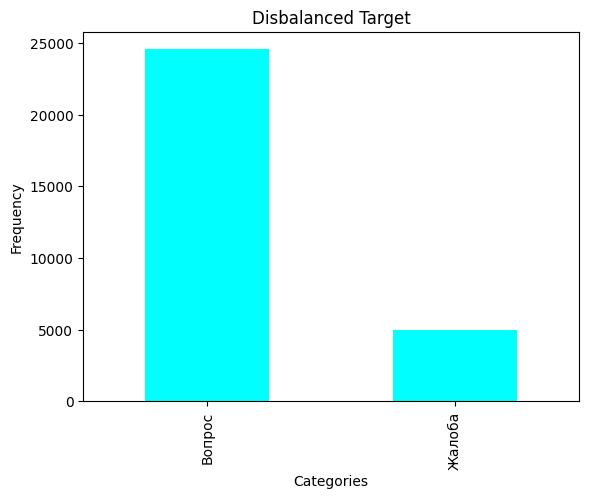

In [11]:
d['category'].value_counts().plot(kind='bar', color=['cyan'])

plt.title('Disbalanced Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

In [12]:
# перекодируем таргет цифрами
d['label'] = d['category'].replace({'Вопрос': 'question', 'Жалоба': 'complaint'})
d.head(30)

,date,category,topic,municipality,text,label
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...,question
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...",question
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...,question
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?,question
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ...",question
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...,complaint
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...,complaint
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...",complaint
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?,question
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что...",question


In [78]:
# проверим данные на пропуски
d.isna().sum()

date             0
category         0
topic           11
municipality     0
text             0
label            0
dtype: int64

В данных имеется доля пропусков в колонке topic. Так как число пропусков < 10% от количества наблюдений, то пропуски можно безопасно удалить.

In [79]:
d = d.dropna()

In [80]:
d.isna().sum()

date            0
category        0
topic           0
municipality    0
text            0
label           0
dtype: int64

In [148]:
d['label'].unique()

array(['question', 'complaint'], dtype=object)

### Изучим текстовые данные

In [81]:
corpus = list(d['text'])
corpus

["'Вид из окна потрясающий (пр. С. Юлаева напротив Юбилейной). Когда наконец уберете эту помойку(сараи, постройки)",
 "'[id294938415:bp-88767010_4|Αнастасия], Здравствуйте, подскажите как оспорить результаты по отказу пособия с 8 до 17? Насчитали большую сумму, а по факту меньше. Как быть?спасибо",
 "'[club53367440:bp-53367440_121743|Министерство], здравствуйте. С 3 до 7 уже направили? Сегодня же только 14",
 "'Здравствуйте когда будет выплата ДВ?",
 "'Девочки всем привет,у меня такой вопрос получила пособие вместо 12444,7 с копейками,детские вчера переоформила которые до 1,5,нам вчера исполнился 1 год,когда придет остальная часть?",
 "'Когда будет приведён в порядок пруд в центре Ивни по улице Луговая? Не просто покос рогоза в январе перед журналистами, а качественная чистка водоёма от рогоза, который превращает пруд в центре посёлка в болото и сборник мусора.",
 "'Обращаюсь от имени одиноких престарелых людей жителей микрорайона Лименды города Котласа. по поводу нововведения передачи

In [82]:
def lemmatize(text):
    m = Mystem()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)

    return lemm_text

def clear_text(text):
    clr = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)
    cleared_text = " ".join(clr.split())
    return cleared_text

In [83]:
# тестируем функции
print("Исходный текст:", corpus[153])
print()
print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[153])))

Исходный текст: 'А,он будет ездить по старому маршруту,через ЛИСКИ,не подскажите???

Очищенный и лемматизированный текст: а он быть ездить по старый маршрут через лиски не подсказывать



In [84]:
m = MorphAnalyzer()

# убираем все небуквенные символы
regex = re.compile("[А-Яа-яA-z]+")


def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

In [85]:
print(d.text[0])

'Вид из окна потрясающий (пр. С. Юлаева напротив Юбилейной). Когда наконец уберете эту помойку(сараи, постройки)


In [86]:
# # создаем новый список для хранения очищенных и лемматизированных текстов
# processed_corpus = []
#
# # проходим по каждому тексту в корпусе, применяем функции лемматизации и очистки текста
# for text in corpus:
#     processed_text = lemmatize(clear_text(text))
#     processed_corpus.append(processed_text)

#### Код выше - корректный, но ввиду большого объема данных циклом обходить весь корпус занимает много времени. Сам по себе Mystem() очень долгий. Нужно какое-то более оптимальное решение.

#### Метод ```@lru_cashe``` создает для функции lemmatize кэш указанного размера, что позволяет в целом ускорить лемматизацию текста (что очень полезно, так как лемматизация - ресурсоемкий процесс).

In [87]:
# create a MorphAnalyzer instance
m = MorphAnalyzer()

# set up regex to extract words from text
regex = re.compile("[А-Яа-яA-z]+")

# set up stopwords
mystopwords = stopwords.words('russian')

# set up lemmatization cache
@lru_cache(maxsize=100000)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

# define text preprocessing function
def clean_text(text):
    # extract words from text
    tokens = regex.findall(text.lower())

    # lemmatize the words
    lemmas = [lemmatize_word(token) for token in tokens]

    # remove stopwords and short words
    words = [word for word in lemmas if word not in mystopwords and len(word) > 3]

    return words

In [88]:
print(*clean_text(d.text[3]))

здравствуйте выплата


In [89]:
text = d.text[13]
cleaned_text = clean_text(text)
print(cleaned_text)

['вопрос', 'администрация', 'город', 'деньга', 'почему', 'содержание', 'животное']


#### Нам нужно предобработать большой объем текста, помимо кэширования может помочь распараллеливание, например, методом Pool библиотеки multiprocessing:

In [90]:
# %%time
# # N = 200
# # with Pool(4) as p:
# #     lemmas = list(tqdm(p.imap(clean_text, data['text']), total=N))
#
# with Pool(4) as p:
#     lemmas = list(tqdm(p.imap(clean_text, d['text']), total=len(d)))
#
# d['lemmas'] = lemmas
# d.sample(5)

Код выше - корректный, однако ввиду большого объема данных лемматизатизация проходит очень долго. Попробуем найти другое решение.

## Начинаем с простых baselines

Это всегда хорошая практика - сначала попробовать что-то предельно простое. В нашем случае это будет логистическая регрессия + мешок слов (Bag of Words, BoW).

In [91]:
d.columns

Index(['date', 'category', 'topic', 'municipality', 'text', 'label'], dtype='object')

In [92]:
data = d[['text', 'label']]

In [93]:
train, test = train_test_split(data, test_size=0.2)

In [94]:
X_train = train.drop(columns=['label'])
y_train = train[['label']]

X_test = test.drop(columns=['label'])
y_test = test[['label']]

In [95]:
train.sample()

,text,label
9129,'Когда наладите рейсы 5 и 5а уже замучили свои...,question


In [96]:
test.sample()

,text,label
629,"'Мамочки!<br>Вчера подала на пособия до 1,6 и ...",question


In [97]:
y_train.sample()

,label
17727,complaint


In [98]:
y_test.sample()

,label
13988,question


In [99]:
y_test = y_test['label'].values
y_test

array(['question', 'complaint', 'question', ..., 'question', 'question',
       'question'], dtype=object)

In [100]:
# строим BoW для слов
vec = CountVectorizer(ngram_range=(1, 1), token_pattern='\w{3,}')

In [101]:
bow = vec.fit_transform(train['text'])
bow

<23630x53146 sparse matrix of type '<class 'numpy.int64'>'
	with 463814 stored elements in Compressed Sparse Row format>

In [102]:
print(train.text[111])

'Скажите, пожалуйста, родителям сообщается, что препарат экспериментальный до декабря 2023 года согласно официальному реестру клинических исследований?


In [103]:
list(vec.vocabulary_.items())[:10]

[('club183841788', 2353),
 ('управление', 49227),
 ('автомобильных', 3492),
 ('дорог', 13255),
 ('брянской', 6389),
 ('области', 27223),
 ('здравствуйте', 16505),
 ('скажите', 43040),
 ('пожалуйста', 33741),
 ('почему', 35592)]

In [104]:
sorted(list(vec.vocabulary_.items()), key=lambda x: x[0])[:10]

[('000', 0),
 ('000не', 1),
 ('000р', 2),
 ('000т', 3),
 ('000тр', 4),
 ('001', 5),
 ('002', 6),
 ('004463', 7),
 ('008', 8),
 ('00ч', 9)]

In [105]:
list(vec.vocabulary_.keys())[:10]

['club183841788',
 'управление',
 'автомобильных',
 'дорог',
 'брянской',
 'области',
 'здравствуйте',
 'скажите',
 'пожалуйста',
 'почему']

In [106]:
len(vec.vocabulary_.items())

53146

### Логистическая регрессия

In [107]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(bow, y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=500, random_state=42)

In [108]:
# len(clf.coef_[0]) returns the length of the clf.coef_[0] array, which is equal to the number of features used in the model.
len(clf.coef_[0])

53146

In [109]:
bow_test = vec.transform(test['text'])
bow_test

<5908x53146 sparse matrix of type '<class 'numpy.int64'>'
	with 108964 stored elements in Compressed Sparse Row format>

In [110]:
pred = clf.predict(bow_test)
pred[:10]

array(['question', 'question', 'question', 'question', 'question',
       'question', 'question', 'question', 'question', 'question'],
      dtype=object)

In [111]:
accuracy_score(pred, y_test)

0.8635748138117806

In [112]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.44      0.68      0.53       674
    question       0.96      0.89      0.92      5234

    accuracy                           0.86      5908
   macro avg       0.70      0.78      0.73      5908
weighted avg       0.90      0.86      0.88      5908



### *Вывод:*

**В данном случае, безо всякой предобработки текста модель логистической регрессии делает предсказания с правильностью 86.5% (0.865).** Посмотрим повнимательнее на classification report.

* Модель достигает общей точности в 0,86, что означает, что она правильно предсказывает метки классов для 86% экземпляров в тестовом наборе.

* Класс question имеет гораздо большее значение support (количество экземпляров в тестовом наборе), чем класс complaint, что указывает на его более частое появление в тестовом наборе. Модель достигает высокой точности (0,95) и полноты (0,89) для класса question, что означает, что она правильно идентифицирует большинство экземпляров этого класса и не ошибается в классификации многих экземпляров как question.

* Класс complaint имеет более низкую точность (0,45) и полноту (0,65) по сравнению с классом question, что означает, что модель менее точно идентифицирует экземпляры этого класса. Это может быть вызвано несколькими причинами, такими как несбалансированность классов, недостаточное количество тренировочных данных или представление признаков, которое не так хорошо выделяет характеристики класса complaint, как это делает для класса question.

* Макро-усредненная F1-мера (0,73) ниже, чем взвешенная средняя F1-мера (0,88), что указывает на то, что производительность модели более сильно зависит от более крупного класса question. Это также может быть признаком несбалансированности классов или смещения модели в сторону большинства классов.

**В целом, отчет о классификации говорит о том, что модель хорошо справляется с классом ```question```, но могла бы получить дополнительные улучшения в классификации класса ```complaint```.**


#### Попробуем добавить препроцессинг текста и посмотрим, улучшится ли качество модели.

Препроцессинг, как правило, включает удаление небуквенных символов, топ-слов и нормализацию (стемминг - приведение к основе слова - или лемматизацию - приведение слов к начальной форме).

Кроме того, заменим мешок слов на TF-IDF матрицу. В качестве модели оставим логистическую регрессию.

### Напишем необходимые функции для препроцессинга.

1. (f1) Функция для удаления небуквенных символов из текста.
2. (f2) Функция для удаления небуквенных символов
2. (f3) Функция для лемматизации.
3. (f4) Функция для удаления коротких (менее 3 символов) и стоп-слов.

In [113]:
# f1
# Создание регулярного выражения для английского алфавита
m = MorphAnalyzer()
# set up regex to extract words from text
regex = re.compile("[А-Яа-яA-z]+")

# set up stopwords
mystopwords = stopwords.words('russian')

def words_only(text, regex=regex):
    try:
        # Приведение текста к нижнему регистру и поиск всех слов, соответствующих регулярному выражению
        return regex.findall(text.lower())
    except:
        # Если происходит ошибка, возвращаем пустой список
        return []

# f2
@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form


# f3
def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

# f4
def remove_stopwords(lemmas, stopwords=mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]


# applying all
def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [114]:
# тестируем обработку
%time clean_text(data.text[13])

CPU times: total: 0 ns
Wall time: 3.13 ms


'вопрос администрация город деньга почему содержание животное'

##### Функции работают, проводим препроцессинг для train и test выборок.

In [115]:
%%time
lemmas = list(tqdm(map(clean_text, train['text']), total=len(train)))

train['lemmas'] = lemmas
train.sample(5)

100%|██████████| 23630/23630 [00:50<00:00, 469.78it/s]

CPU times: total: 29.3 s
Wall time: 50.3 s


,text,label,lemmas
14672,'Мне вот всю жизнь интересно было где это всё ...,question,весь жизнь интересно проводиться новостройка п...
9936,'А палатки из не горючего материала будут?,question,палатка горючее материал
15691,'Подскажите пожалуйста что будет учитываться п...,question,подсказать пожалуйста учитываться переоформлен...
222,'Что за перебои с электричеством????,question,перебой электричество
23918,"'Здравствуйте Вячеслав Владимирович, писала ва...",complaint,здравствуйте вячеслав владимирович писать личн...


In [116]:
%%time
lemmas_test = list(tqdm(map(clean_text, test['text']), total=len(test)))

test['lemmas'] = lemmas_test
test.sample(5)

100%|██████████| 5908/5908 [00:12<00:00, 454.67it/s]

CPU times: total: 5.48 s
Wall time: 13 s


,text,label,lemmas
15233,"'Здравствуйте, назначена выплата с 8 до 17 еще...",question,здравствуйте назначить выплата поступление ник...
7072,"'Здравствуйте, пожалуйста скажите, сами выплат...",question,здравствуйте пожалуйста сказать выплата детски...
10327,'Здравствуйте. Хочу спросить сколько будет дли...,question,здравствуйте хотеть спросить сколько длиться р...
4587,"'Здравствуйте,скажите пожалуйста в каких числа...",question,здравствуйте сказать пожалуйста число выплачив...
25995,"'[id431723134|Мария], я в апреле получила 2500...",question,мария] апрель получить июнь сколько получить с...


#### Считаем TF-IDF матрицу и обучаем модель:

In [117]:
vec = TfidfVectorizer(ngram_range=(1, 2)) # строим BoW для слов
tfidf = vec.fit_transform(train['lemmas'])

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(tfidf, y_train)

pred = clf.predict(vec.transform(test['lemmas']))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8586662153012864

In [118]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.32      0.72      0.45       465
    question       0.97      0.87      0.92      5443

    accuracy                           0.86      5908
   macro avg       0.65      0.80      0.68      5908
weighted avg       0.92      0.86      0.88      5908



In [119]:
vec = TfidfVectorizer(ngram_range=(1, 4))  # строим BoW для слов
tfidf = vec.fit_transform(train['lemmas'])

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(tfidf, y_train)

pred = clf.predict(vec.transform(test['lemmas']))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8593432633716994

In [120]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.37      0.69      0.48       551
    question       0.97      0.88      0.92      5357

    accuracy                           0.86      5908
   macro avg       0.67      0.78      0.70      5908
weighted avg       0.91      0.86      0.88      5908



### *Вывод:* После предобработки accuracy не сильно возросла, однако по матрице несоответствий можно сделать следующие выводы:

* Для категории "complaint" точность (precision) невысока (0.34), что означает, что большинство сообщений, которые модель относит к данной категории, на самом деле не являются жалобами. Однако полнота (recall) высока (0.70), что говорит о том, что модель находит большую часть настоящих жалоб.
* Для категории "question" точность очень высока (0.97), то есть большинство сообщений, которые модель относит к данной категории, на самом деле являются вопросами. Полнота также высока (0.88).
* Средние значения метрик (macro avg) говорят о том, что модель работает достаточно хорошо в целом для обеих категорий.
* Взвешенное среднее (weighted avg) показывает, что общая точность модели достаточно высока (0.92), однако также видно, что модель лучше справляется с классификацией "question", чем с "complaint".

**Можно заметить, что модель справляется неплохо с задачей классификации. Попробуем улучшить преобработку и применить разные модели классификации.**

### Word2Vec

*Попробуем использовать эмбеддинги слов - для этого сперва обучим модель Word2Vec c помощью библиотеки gensim.*

Выполним обучение модели ```Word2Vec``` на токенизированных комментариях, хранящихся в столбце ```'lemmas'``` датафрейма train. Каждый комментарий разбивается на отдельные слова (токены), которые используются для обучения модели.

#### Параметры функции Word2Vec:

* ```workers=4``` - количество потоков, используемых для обучения модели;
* ```vector_size=200``` - размерность векторов слов, которые будут получены в результате обучения;
* ```min_count=10``` - минимальное количество вхождений слова в корпус, которое необходимо для его участия в обучении модели;
* ```window=5``` - размер окна, в котором рассматриваются слова в тексте при обучении модели;
* ```sample=1e-3``` - порог для downsampling'а частых слов, чтобы уменьшить их вес в обучении и повысить значимость менее частых слов.

In [121]:
tokenized_comment = [comment.split() for comment in train['lemmas'].values]

%time
w2v = word2vec.Word2Vec(tokenized_comment, workers=4, vector_size=200, min_count=10, window=5, sample=1e-3)

CPU times: total: 0 ns
Wall time: 0 ns


In [122]:
tokenized_comment

[['[club',
  'управление',
  'автомобильный',
  'дорога',
  'брянский',
  'области]',
  'здравствуйте',
  'сказать',
  'пожалуйста',
  'почему',
  'почепский',
  'район',
  'посёлок',
  'октябрьский',
  'улица',
  'октябрьский',
  'щебёнка',
  'насыпать',
  'место',
  'начало',
  'улица',
  'подсыпка',
  'небыть',
  'произвести',
  'счий',
  'связать'],
 ['здравствуйте',
  'подсказать',
  'пожалуйста',
  'нижеперечисленный',
  'детский',
  'лагерь',
  'республика',
  'учавствовать',
  'программа',
  'детский',
  'кэшбэк',
  'http',
  'cheremushki',
  'https',
  'sunblag',
  'ucoz'],
 ['здравствуйте',
  'дать',
  'вода',
  'горячий',
  'сопляков',
  'вода',
  'вчерашний',
  'день'],
 ['здравствуйте',
  'почему',
  'республика',
  'транспортный',
  'налог',
  'выше',
  'соседний',
  'оренбургский',
  'область'],
 ['здравствуйте',
  'хотеть',
  'узнать',
  'условие',
  'получать',
  'выплата',
  'женщина',
  'встать',
  'ранний',
  'срок'],
 ['здравствуйте', 'многодетный', 'скидка', 'детс

#### Теперь у нас есть эмбеддинги для слов. Но как получить эмбеддинги для целого комментария? Можно усреднить эмбеддинги слов, входящих в комментарий.

In [123]:
def get_comment_embedding(lemmas, model=w2v.wv, embedding_size=200):

    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

In [124]:
get_comment_embedding('text')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Для каждого комментария из обучающей и тестовой выборки вычислим такой эмбеддинг:

In [125]:
train['w2v_embedding'] = train['lemmas'].map(get_comment_embedding)
test['w2v_embedding'] = test['lemmas'].map(get_comment_embedding)

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['w2v_embedding'].values), y_train)

pred = clf.predict(list(test['w2v_embedding'].values))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8322613405551794

In [126]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.14      0.61      0.23       245
    question       0.98      0.84      0.91      5663

    accuracy                           0.83      5908
   macro avg       0.56      0.73      0.57      5908
weighted avg       0.95      0.83      0.88      5908



### *Вывод:* Качество модели упало, значит Word2Vec точно не подходит для обработки текста в данной задаче.

Классификатор показывает высокую точность в определении вопросов, но низкую точность в определении жалоб. Точность определения жалоб составляет всего 13%, что означает, что из всех определенных как жалобы, только 13% действительно являются жалобами. Однако, показатели полноты и точности в определении вопросов составляют 0.98 и 0.85 соответственно, что говорит о высокой точности и полноте в определении вопросов. Метрика F1-score на уровне 0.21 и в целом она является низкой.

## FastText

FastText - это модификация модели word2vec.

FastText использует не только векторы слов, но и векторы n-грам. В корпусе каждое слово автоматически представляется в виде набора символьных n-грамм. Скажем, если мы установим n=3, то вектор для слова "where" будет представлен суммой векторов следующих триграм: "<wh", "whe", "her", "ere", "re>" (где "<" и ">" символы, обозначающие начало и конец слова). Благодаря этому мы можем также получать вектора для слов, отсутствуюших в словаре, а также эффективно работать с текстами, содержащими ошибки и опечатки.

* [Статья](https://aclweb.org/anthology/Q17-1010)
* [Сайт](https://fasttext.cc/)
* [Руководство](https://fasttext.cc/docs/en/support.html)
* [Репозиторий](https://github.com/facebookresearch/fasttext)

Есть библиотека `fasttext` для питона (с готовыми моделями можно работать и через `gensim`).

На сайте проекта можно найти предобученные модели для 157 языков (в том числе русского): https://fasttext.cc/docs/en/crawl-vectors.html

Для начала, попробуем взять предобученную модель fastText с сайта проекта и заменить эмбеддинги в модели выше на эмбеддинги fastText.

Можно попробовать взять модель с сайта проекта Rusvetores: https://rusvectores.org/ru/models/

In [127]:
help(fasttext.util.download_model)

Help on function download_model in module fasttext.util.util:

download_model(lang_id, if_exists='strict', dimension=None)
    Download pre-trained common-crawl vectors from fastText's website
    https://fasttext.cc/docs/en/crawl-vectors.html



In [128]:
%%time
# Загрузка модели, если ее нет на диске ==> ОЧЕНЬ МНОГО ВЕСИТ

# fasttext.util.download_model('ru', if_exists='ignore') # russian ==> ЗАГРУЖЕНА ЛОКАЛЬНО
# fasttext.util.download_model('en', if_exists='ignore') # english

CPU times: total: 0 ns
Wall time: 0 ns


In [129]:
# Загрузка модели в переменную ft
ft = fasttext.load_model("C:\\Users\\HOME\\PycharmProjects\\cc.ru.300.bin") # модель весит 7 Гб, лежит локально

In [130]:
ft['парковый очень красивый неужели пила']

array([-4.35059052e-03, -3.55695793e-03,  1.58397609e-03, -1.31041333e-02,
       -7.87809864e-03,  4.54303576e-03,  1.04006974e-03, -1.80274190e-04,
       -1.24827363e-02,  9.26701073e-03,  7.43316486e-03, -2.52725109e-02,
       -1.15026105e-02,  1.73878949e-03,  7.44686229e-03, -1.22938519e-02,
       -7.29628047e-03,  7.33408472e-03, -1.56296827e-02, -6.07067393e-03,
        1.73137933e-02,  7.57565373e-04, -2.14581814e-04,  9.62902699e-03,
        1.51335122e-02,  3.21272761e-03,  5.74692152e-03,  9.82438400e-03,
        1.36665022e-02, -2.03599669e-02,  9.70651302e-03, -1.39907701e-02,
        1.59544516e-02, -1.40423868e-02,  1.23823062e-02, -8.17978568e-03,
        6.48655090e-03, -3.22098844e-02,  2.48824283e-02, -2.96643865e-03,
        2.81910971e-03, -1.59070343e-02,  1.64397131e-03,  5.22648683e-03,
       -3.38745536e-03,  1.42006660e-02, -2.08896725e-03, -9.78665799e-03,
        6.10517850e-03,  5.20809507e-03,  1.30556151e-02,  2.33448576e-02,
        1.48877222e-02,  

In [131]:
x = 'парковый очень красивый неужели пила'
get_comment_embedding(x, model=ft, embedding_size=300)

array([ 0.01625473,  0.00829152, -0.00126097,  0.02905879,  0.02823407,
       -0.03041483, -0.03086586,  0.02289047, -0.04900266,  0.02815436,
        0.02625005,  0.03469973,  0.00199546,  0.02783065, -0.0363468 ,
       -0.00846948,  0.02456651, -0.00123474, -0.01385996,  0.00020733,
        0.01313574, -0.078882  ,  0.03972147,  0.03464337,  0.03299493,
       -0.00444709,  0.02087226,  0.03203575, -0.01421488,  0.00806902,
        0.02245799, -0.0216795 ,  0.01419253, -0.01919321,  0.03188244,
       -0.01646302,  0.00893144, -0.13303685, -0.02057134, -0.02821044,
       -0.00839118, -0.01133353,  0.01330306,  0.03265403, -0.00125835,
        0.02956294, -0.03214562,  0.00694021,  0.01470614,  0.05039065,
        0.02668291, -0.01293064, -0.03571518,  0.08411254, -0.01901203,
        0.00656017,  0.00691449, -0.01054051,  0.00186629, -0.00523254,
        0.0152056 , -0.01624435,  0.03386005,  0.02345904, -0.00533265,
        0.01555425, -0.04247219,  0.05884881, -0.03249846, -0.00

In [132]:
# немного изменим функцию, что мы писали выше, уберем проверку на входждении, чтобы увеличить скорость
def get_com_embedding(lemmas, model=w2v.wv, embedding_size=200):

    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        # if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

In [133]:
%%time
# добавляем колонку с очищенным текстом с помощью Fasttext
train['ft_embedding'] = train['text'].apply(lambda x: get_com_embedding(x, model=ft, embedding_size=300))
print('TRAIN COMPLETED')

test['ft_embedding'] = test['text'].apply(lambda x: get_com_embedding(x, model=ft, embedding_size=300))
print('TEST COMPLETED')

TRAIN COMPLETED
TEST COMPLETED
CPU times: total: 8.47 s
Wall time: 16.6 s


In [134]:
train.head(10)

,text,label,lemmas,w2v_embedding,ft_embedding
25259,'[club183841788|Управление автомобильных дорог...,question,[club управление автомобильный дорога брянский...,"[-0.14051144269457005, -0.1552520468223678, 0....","[-0.004624185028232579, -0.004286046557621483,..."
27089,'Здравствуйте. Подскажите пожалуйста будут ли ...,question,здравствуйте подсказать пожалуйста нижеперечис...,"[-0.054137665405869485, -0.14763788590207697, ...","[0.026183532900176942, -0.014607321356379543, ..."
11422,"'Здравствуйте, когда дадут воду горячую по ул,...",question,здравствуйте дать вода горячий сопляков вода в...,"[0.36249091050454546, -0.430349307933024, -0.3...","[0.04098835268702645, 0.010228924856234629, -0..."
23058,'Здравствуйте!<br>А почему у нас в республике ...,question,здравствуйте почему республика транспортный на...,"[0.027256734436377883, -0.02730801305733621, 0...","[0.03855233149287025, -0.0046373391108188245, ..."
5697,"'Здравствуйте, я бы хотела узнать, какие услов...",question,здравствуйте хотеть узнать условие получать вы...,"[0.253180006891489, -0.10960336830466985, -0.0...","[0.036777772576897405, -0.027003610288375057, ..."
11256,'Здравствуйте. Если многодетным скидка в детск...,question,здравствуйте многодетный скидка детский лагерь,"[0.11823539286851883, -0.048036873899400236, 0...","[0.03070512626852308, -0.00950161274522543, -0..."
1766,"'[club201474397|ЦУР Астраханской области], све...",question,[club астраханский области] светофор починить ...,"[-0.3271739653369877, -0.1494595766067505, 0.2...","[0.02403966471320018, -0.01887328299926594, -0..."
22372,"'[club66711154|Архангельская область], Литейна...",complaint,[club архангельский область] литейный вода,"[-0.17499752435833216, -0.30282022804021835, -...","[0.013432639262949428, -0.026023644585317623, ..."
26714,"'Игорь Юрьевич, добрый день, помогите решить в...",question,игорь юриевич добрый день помочь решить вопрос...,"[0.1190454640518277, -0.13244883818790698, -0....","[0.012969464811197083, -0.01486245509960489, -..."
27121,'Здравствуйте. Когда же наконец то сделают дор...,question,здравствуйте сделать дорога дубравка метр весь...,"[-0.019193499597072925, -0.14683525365493869, ...","[0.0028524269287507715, -0.02943862642416553, ..."


In [135]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['ft_embedding'].values), y_train)

pred = clf.predict(list(test['ft_embedding'].values))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8476641841570751

In [136]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.20      0.76      0.32       282
    question       0.99      0.85      0.91      5626

    accuracy                           0.85      5908
   macro avg       0.59      0.80      0.62      5908
weighted avg       0.95      0.85      0.89      5908



print(train.shape)
print(y_train.shape)

### *Вывод:* Данные очищены от странных букв и знаков, знаки пунктуации и стоп-слова удалены, данные разделены на тестовую и обучающую выборки, в каждой из которой выделены признаки и целевое значение. Выборки признаков приведены к векторному виду и готовы к обучению.

## Модели
### 1) Логистическая регрессия

In [137]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['ft_embedding'].values), y_train)

prediction = clf.predict(list(test['ft_embedding'].values))
accuracy_score(pred, y_test)

print("\naccuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nf1-score: {}%".format(f1_score(y_test, prediction, average='weighted')))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



accuracy: 84.77%

f1-score: 0.8094263692415901%

 [[ 213  831]
 [  69 4795]]

               precision    recall  f1-score   support

   complaint       0.76      0.20      0.32      1044
    question       0.85      0.99      0.91      4864

    accuracy                           0.85      5908
   macro avg       0.80      0.59      0.62      5908
weighted avg       0.84      0.85      0.81      5908



#### Или с использованием контейнера.

In [152]:
pipe_lr = Pipeline([('model', LogisticRegression())])
pipe_lr.fit(train['ft_embedding'].values.tolist(), y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('model', LogisticRegression())])

In [153]:
prediction = pipe_lr.predict(test['ft_embedding'].values.tolist())

In [154]:
print("\naccuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nf1-score: {}%".format(f1_score(y_test, prediction, average='weighted')))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))


accuracy: 84.77%

f1-score: 0.8094263692415901%

 [[ 213  831]
 [  69 4795]]

               precision    recall  f1-score   support

   complaint       0.76      0.20      0.32      1044
    question       0.85      0.99      0.91      4864

    accuracy                           0.85      5908
   macro avg       0.80      0.59      0.62      5908
weighted avg       0.84      0.85      0.81      5908



**Для более точного подбора гиперпараметров применим поиск по сетке.**

In [150]:
from sklearn.metrics import f1_score, make_scorer

def f1_score_pos(y_true, y_pred, pos_label):
    return f1_score(y_true, y_pred, pos_label=pos_label)

f1_scorer = make_scorer(f1_score_pos, pos_label='complaint')

In [151]:
%%time
# logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

param_grid = [    {'C': [0.01, 0.1, 1, 2, 10, 100],
     'penalty': ['l2']}
]

logreg_grid = GridSearchCV(logreg,
                           param_grid,
                           cv=3,
                           verbose=False,
                           n_jobs=-1,
                           scoring=f1_scorer)

logreg_grid.fit(train['ft_embedding'].values.tolist(), y_train)

pred_final = logreg_grid.predict(test['ft_embedding'].values.tolist())

print("\naccuracy: {}%".format(round(accuracy_score(y_test, pred_final)*100,2)))
print("\nf1-score: {}".format(f1_score(y_test, pred_final, average='weighted')))
print('\n',confusion_matrix(y_test, pred_final))
print('\n',classification_report(y_test, pred_final))

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



accuracy: 78.66%

f1-score: 0.8077901873294645

 [[ 862  182]
 [1079 3785]]

               precision    recall  f1-score   support

   complaint       0.44      0.83      0.58      1044
    question       0.95      0.78      0.86      4864

    accuracy                           0.79      5908
   macro avg       0.70      0.80      0.72      5908
weighted avg       0.86      0.79      0.81      5908

CPU times: total: 8.67 s
Wall time: 26.5 s


#### Логистическая регрессия позволяет получить такие результаты, что:

* accuracy: 78.66%

* f1-score: 0.8077901873294645

Матрица несоответствий указывает, что модель показывает лучшие результаты в определении примеров класса 'question', что отражается в более высоких значениях точности, полноты и f1-меры для этого класса. Однако модель неправильно классифицирует многие примеры класса 'complaint' как примеры класса 'question', что отражается в более низких значениях точности, полноты и f1-меры для класса 'complaint'.

### 2) CatBoost

Гиперпараметры подберем поиском по сетке со встроенной кросс-валидацией:

* **iterations**: Количество итераций бустинга. Этот гиперпараметр контролирует количество деревьев решений в модели.

* **learning_rate**: Скорость обучения для градиентного бустинга. Этот гиперпараметр контролирует размер шага, используемого для обновления весов деревьев решений во время обучения.

* **depth:** Максимальная глубина каждого дерева решений. Этот гиперпараметр контролирует сложность модели и может помочь предотвратить переобучение.

* **l2_leaf_reg**: Коэффициент L2-регуляризации для весов листьев. Этот гиперпараметр помогает предотвратить переобучение путем штрафования больших весов.

* **border_count:** Количество разбиений для числовых признаков. Этот гиперпараметр контролирует гранулярность разбиений признаков и может помочь предотвратить переобучение.

* **bootstrap_type:** Тип бутстрэпа, используемый для выборки наблюдений для каждого дерева. Этот гиперпараметр контролирует случайность обучающих данных и может помочь предотвратить переобучение.

In [ ]:
%%time
catboost = CatBoostClassifier(random_seed=42,
                              loss_function='Logloss')

# preparing parameters to ask GridSearch, which contains cross validation
parameters_cat = {'iterations': [50],
                  'learning_rate': np.arange(0.1, 1, 0.2),
                  'depth': [4, 6, 8],
                  'l2_leaf_reg': [0.01, 0.1, 1],
                  # 'bagging_temperature': [0.2, 0.5, 0.8],
                  'border_count': [32, 64, 128],
                  # 'colsample_bylevel': [0.5, 0.8, 1],
                  # 'bootstrap_type': ['Bayesian', 'Poisson', 'MVS']
                  }

gsearch_catboost = GridSearchCV(catboost,
                                param_grid=parameters_cat,
                                cv=3,
                                verbose=False,
                                scoring=f1_scorer)

gsearch_catboost.fit(list(train['ft_embedding'].values), y_train)

0:	learn: 0.6274428	total: 60.1ms	remaining: 2.94s
1:	learn: 0.5775551	total: 250ms	remaining: 6s
2:	learn: 0.5381686	total: 324ms	remaining: 5.08s
3:	learn: 0.5035224	total: 335ms	remaining: 3.85s
4:	learn: 0.4787402	total: 345ms	remaining: 3.11s
5:	learn: 0.4584293	total: 356ms	remaining: 2.61s
6:	learn: 0.4426934	total: 365ms	remaining: 2.25s
7:	learn: 0.4285446	total: 376ms	remaining: 1.97s
8:	learn: 0.4182994	total: 386ms	remaining: 1.76s
9:	learn: 0.4082649	total: 396ms	remaining: 1.58s
10:	learn: 0.3999516	total: 406ms	remaining: 1.44s
11:	learn: 0.3936061	total: 416ms	remaining: 1.32s
12:	learn: 0.3877907	total: 426ms	remaining: 1.21s
13:	learn: 0.3835625	total: 436ms	remaining: 1.12s
14:	learn: 0.3793701	total: 446ms	remaining: 1.04s
15:	learn: 0.3753257	total: 455ms	remaining: 967ms
16:	learn: 0.3716582	total: 464ms	remaining: 901ms
17:	learn: 0.3687850	total: 473ms	remaining: 841ms
18:	learn: 0.3664008	total: 482ms	remaining: 787ms
19:	learn: 0.3641551	total: 492ms	remaining

In [143]:
y_pred_catboost = gsearch_catboost.predict(list(test['ft_embedding'].values))

print("\naccuracy: {}%".format(round(accuracy_score(y_test, y_pred_catboost)*100, 2)))
print("\nf1-score: {}".format(f1_score(y_test, y_pred_catboost, average='weighted')))
print('\n', confusion_matrix(y_test, y_pred_catboost))
print('\n', classification_report(y_test, y_pred_catboost))


accuracy: 84.33%

f1-score: 0.8030524070876711

 [[ 195  849]
 [  77 4787]]

               precision    recall  f1-score   support

   complaint       0.72      0.19      0.30      1044
    question       0.85      0.98      0.91      4864

    accuracy                           0.84      5908
   macro avg       0.78      0.59      0.60      5908
weighted avg       0.83      0.84      0.80      5908



### 3) Градиентный бустинг LightGBM

Гиперпараметры:

* n_estimators: Количество деревьев решений в градиентном бустинге.
* learning_rate: Скорость обучения для градиентного бустинга. Этот гиперпараметр контролирует размер шага, используемого для обновления весов деревьев решений во время обучения.
* verbose: Уровень логгирования. Чем выше значение, тем больше информации будет выведено во время обучения.
* boosting_type: Тип бустинга, который будет использоваться. В данном случае используется градиентный бустинг деревьев решений.
* num_leaves: Максимальное количество листьев в каждом дереве решений.
* max_depth: Максимальная глубина каждого дерева решений.
* min_split_gain: Минимальный прирост функции потерь, который необходим для совершения разбиения в вершине дерева.
* min_child_samples: Минимальное количество объектов, которые должны находиться в листе дерева.
* subsample: Доля выборки, которая будет использоваться для обучения каждого дерева.
* subsample_freq: Частота использования подвыборки при построении дерева. Если значение равно 0, то подвыборка будет использоваться только один раз.
* colsample_bytree: Доля признаков, которые будут использоваться для построения каждого дерева.
* reg_alpha: L1-регуляризация коэффициентов модели.
* reg_lambda: L2-регуляризация коэффициентов модели.
* random_state: Задает начальное состояние генератора случайных чисел, что позволяет получать воспроизводимые результаты.
* silent: Если значение равно True, то логгирование будет отключено.

In [144]:
%%time
model = lgb.LGBMClassifier(class_weight = 'balanced',
                           random_state=42)

params_LGBMClassifier = {

    'n_estimators': [20, 50, 100],
    'learning_rate': [0.05, 0.1],
    'verbose' : [-1],
#     'boosting_type' : ['gbdt'],
#     'num_leaves': [100],
    'max_depth' : [-1],
#     'min_split_gain' : [0.0],
#     'min_child_samples' : [20],
#     'subsample' : [1.0],
#     'subsample_freq' : [0],
#     'colsample_bytree': [1.0],
#     'reg_alpha' : [0.0],
#     'reg_lambda' : [0.0],
    'random_state' : [42],
#     'silent' : [True]
}

LGBMClassifier_gsearch = GridSearchCV(estimator=model,
                                     cv=3,
                                     param_grid=params_LGBMClassifier,
                                     scoring='f1')

LGBMClassifier_gsearch.fit(list(train['ft_embedding'].values), y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validat

CPU times: total: 3min 59s
Wall time: 31.3 s


GridSearchCV(cv=3,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [-1],
                         'n_estimators': [20, 50, 100], 'random_state': [42],
                         'verbose': [-1]},
             scoring='f1')

In [145]:
y_pred_lightgbm = LGBMClassifier_gsearch.predict(list(test['ft_embedding'].values))

print("\naccuracy: {}%".format(round(accuracy_score(y_test, y_pred_lightgbm)*100,2)))
print("\nf1-score: {}".format(f1_score(y_test, y_pred_lightgbm, average='weighted')))
print('\n',confusion_matrix(y_test, y_pred_lightgbm))
print('\n',classification_report(y_test, y_pred_lightgbm))


accuracy: 76.44%

f1-score: 0.7870503644701684

 [[ 768  276]
 [1116 3748]]

               precision    recall  f1-score   support

   complaint       0.41      0.74      0.52      1044
    question       0.93      0.77      0.84      4864

    accuracy                           0.76      5908
   macro avg       0.67      0.75      0.68      5908
weighted avg       0.84      0.76      0.79      5908



### Сравним модели

In [146]:
# Logistic Regression
best_score_logreg = round(logreg_grid.best_score_, 4)
print('Best score Logistic Regression (Fasttext): {:.2f}'.format(best_score_logreg))

# CatBoost
best_score_catboost = round(gsearch_catboost.best_score_, 4)
print('Best score CatBoostClassifier (Fasttext): {}'.format(best_score_catboost))

# LGBMClassifier
best_score_LGBM = round(LGBMClassifier_gsearch.best_score_, 4)
print('Best score LGBMClassifier (Fasttext): {}'.format(best_score_LGBM))

Best score Logistic Regression (Fasttext): nan
Best score CatBoostClassifier (Fasttext): nan
Best score LGBMClassifier (Fasttext): nan


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


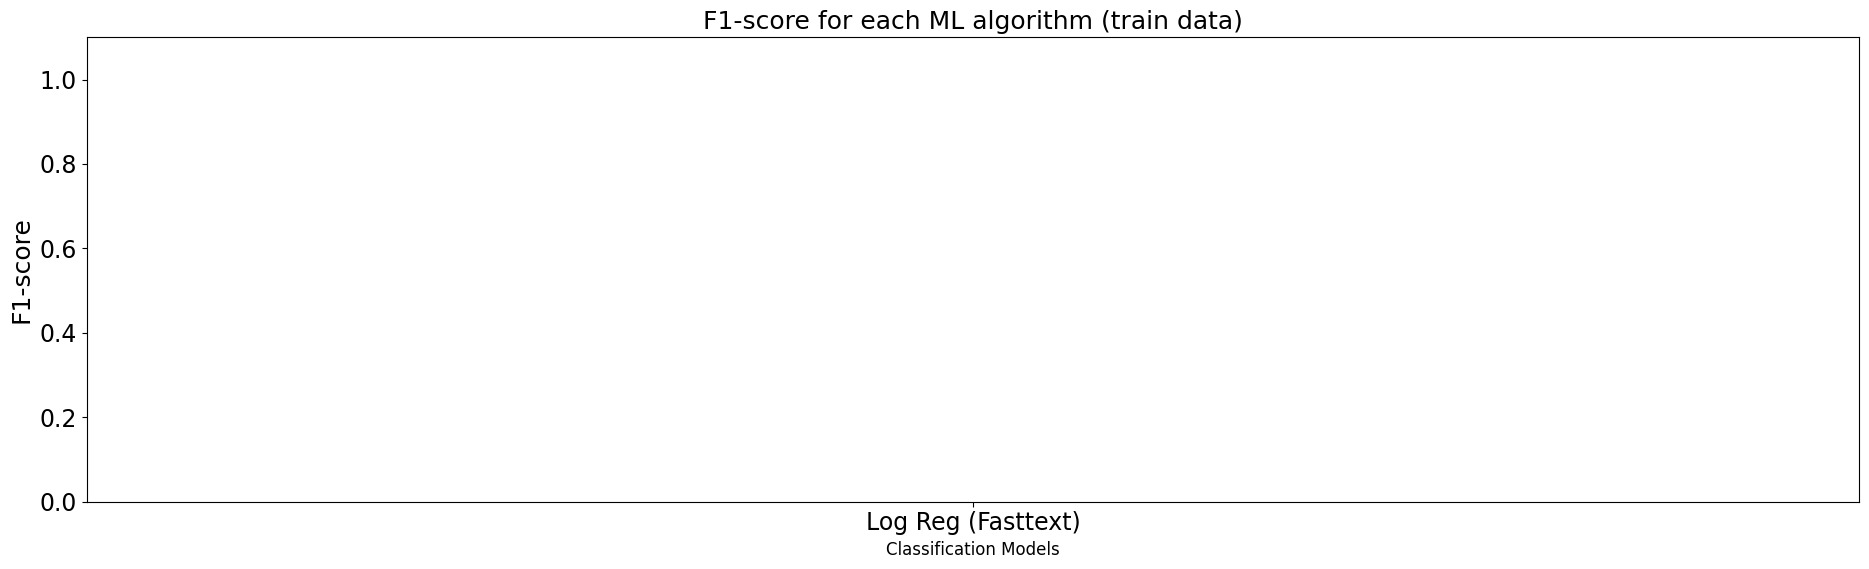

In [147]:
# Generate F1-score plots

plt.rcParams.update({'font.size': 17,
                     'text.color' : 'black',
                     'axes.labelcolor' : "blue"})
# plt.rcParams.update({'axes.titlesize': 'large'})
fig, ax = plt.subplots(figsize=(19, 6))

x = ['Log Reg (Fasttext)',
     'Cat Boost',
    'LightGBM']

y = [best_score_logreg,
     best_score_catboost,
     best_score_LGBM]

ax.bar(x, y, width=0.4, color='#008B8B')
ax.set_title('F1-score for each ML algorithm (train data)', fontsize=18)
ax.set_xlabel('Classification Models', fontsize=12)
ax.set_ylabel('F1-score', fontsize=18)
ax.set_ylim(0, 1.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')

plt.tight_layout();